In [1]:
!python3 --version
import tensorflow as tf
print("Tensorflow", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage
import skimage.draw
import cv2
import random
import math
import re
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import tifffile as tiff

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from custom_multi import nms_suppression_multi
from custom_multi import CustomConfig, CustomDataset

Python 3.9.18
Tensorflow 2.15.0
Num GPUs Available:  0
Device mapping: no known devices.


In [2]:
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  # To find local version of the library
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

## Params

In [3]:
num_gpu = 1 # Number of GPUs to use
num_img_per_gpu = 1 # Batch size
detection_min_confidence = 0.1 # Minimum confidence level for detection
detection_nms_threshold = 0.3 # NMS threshold for detection

weights_subpath = 'multicell20240417T1006/mask_rcnn_multicell_0050.h5'
results_name = 'test_cropper'

test_dir = '/Users/tom/Desktop/Stanford/RA/OligodendroSight/OL_mrcnn/data/test/imgs'

In [7]:
class InferenceConfigMulti(CustomConfig):
    GPU_COUNT = num_gpu
    IMAGES_PER_GPU = num_img_per_gpu
    DETECTION_MIN_CONFIDENCE = detection_min_confidence #Minimum probability value to accept a detected instance
    DETECTION_NMS_THRESHOLD = detection_nms_threshold # Non-maximum suppression threshold for detection

inference_config_multi = InferenceConfigMulti()

macro_model = modellib.MaskRCNN(mode="inference",
                            config=inference_config_multi,
                            model_dir=DEFAULT_LOGS_DIR)

MACRO_WEIGHTS_SUBPATH = weights_subpath
macro_model_path = os.path.join(DEFAULT_LOGS_DIR, MACRO_WEIGHTS_SUBPATH)

print("Loading macro weights from ", macro_model_path)
macro_model.load_weights(macro_model_path, by_name=True) #deprecated on MacOS
#tf.keras.Model.load_weights(macro_model.keras_model, macro_model_path , by_name=True, skip_mismatch=True)

RESULTS_NAME = results_name
RESULTS_DIR = os.path.join(ROOT_DIR, "results", RESULTS_NAME)
os.makedirs(RESULTS_DIR, exist_ok=True)

Loading macro weights from  /Users/tom/Desktop/Stanford/RA/OligodendroSight/OL_mrcnn/logs/multicell20240417T1006/mask_rcnn_multicell_0050.h5


2024-04-19 16:47:28.431122: W tensorflow/c/c_api.cc:305] Operation '{name:'bn2b_branch2b_1/gamma/Assign' id:10412 op device:{requested: '', assigned: ''} def:{{{node bn2b_branch2b_1/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn2b_branch2b_1/gamma, bn2b_branch2b_1/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [8]:
# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(ROOT_DIR+"/data", "valid")
dataset_val.prepare()

281.it12.20x.r1.3.tif


2024-04-19 16:47:35.151828: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_detection_1/Reshape_1' id:16915 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection_1/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection_1/packed, mrcnn_detection_1/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
W0000 00:00:1713570455.704531       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } input

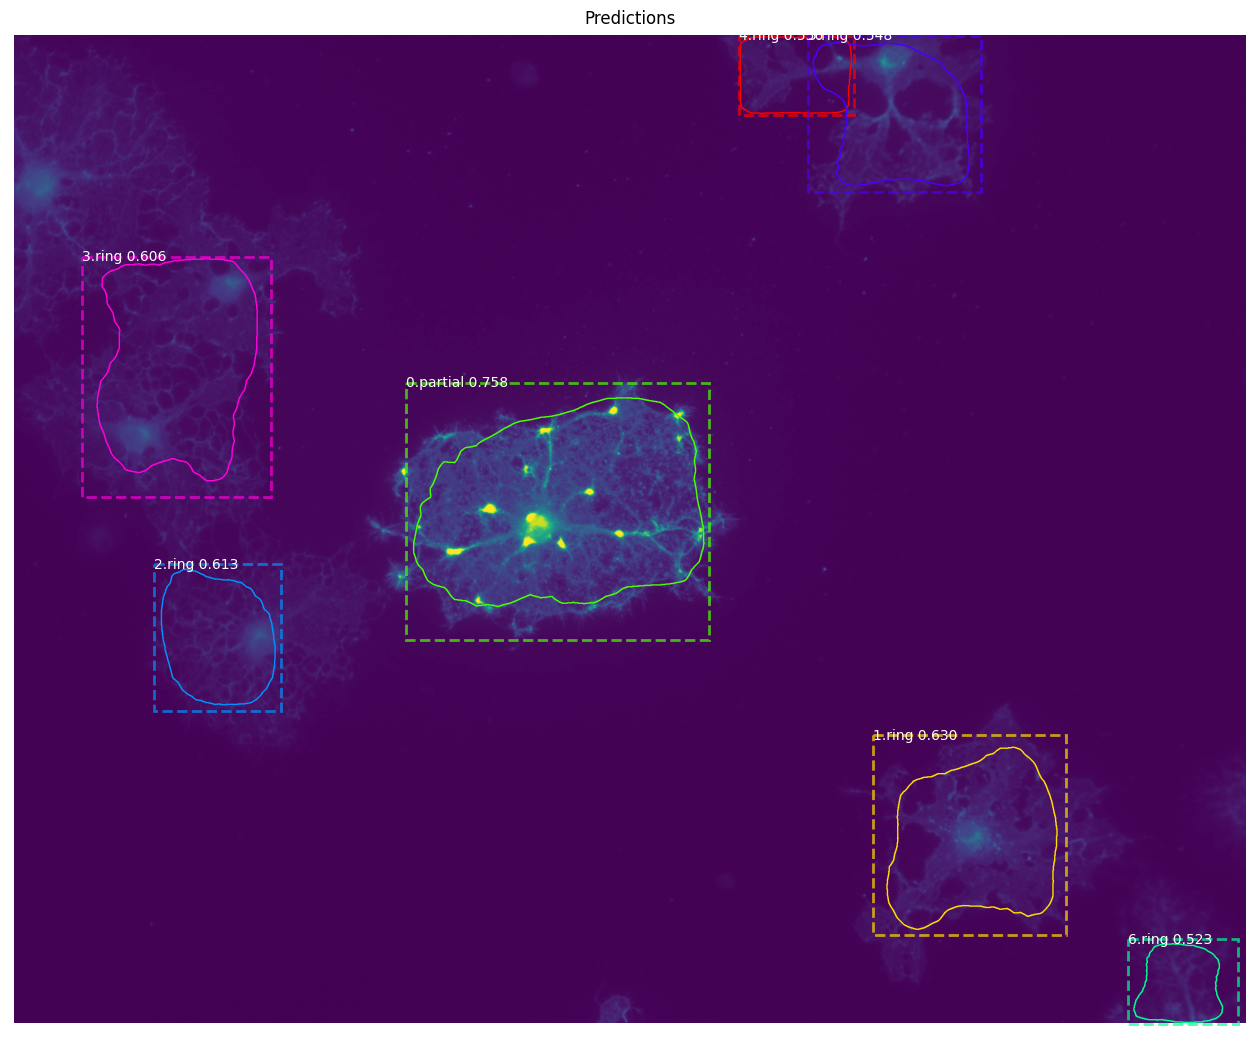

281.it10.20x.r3.8.tif


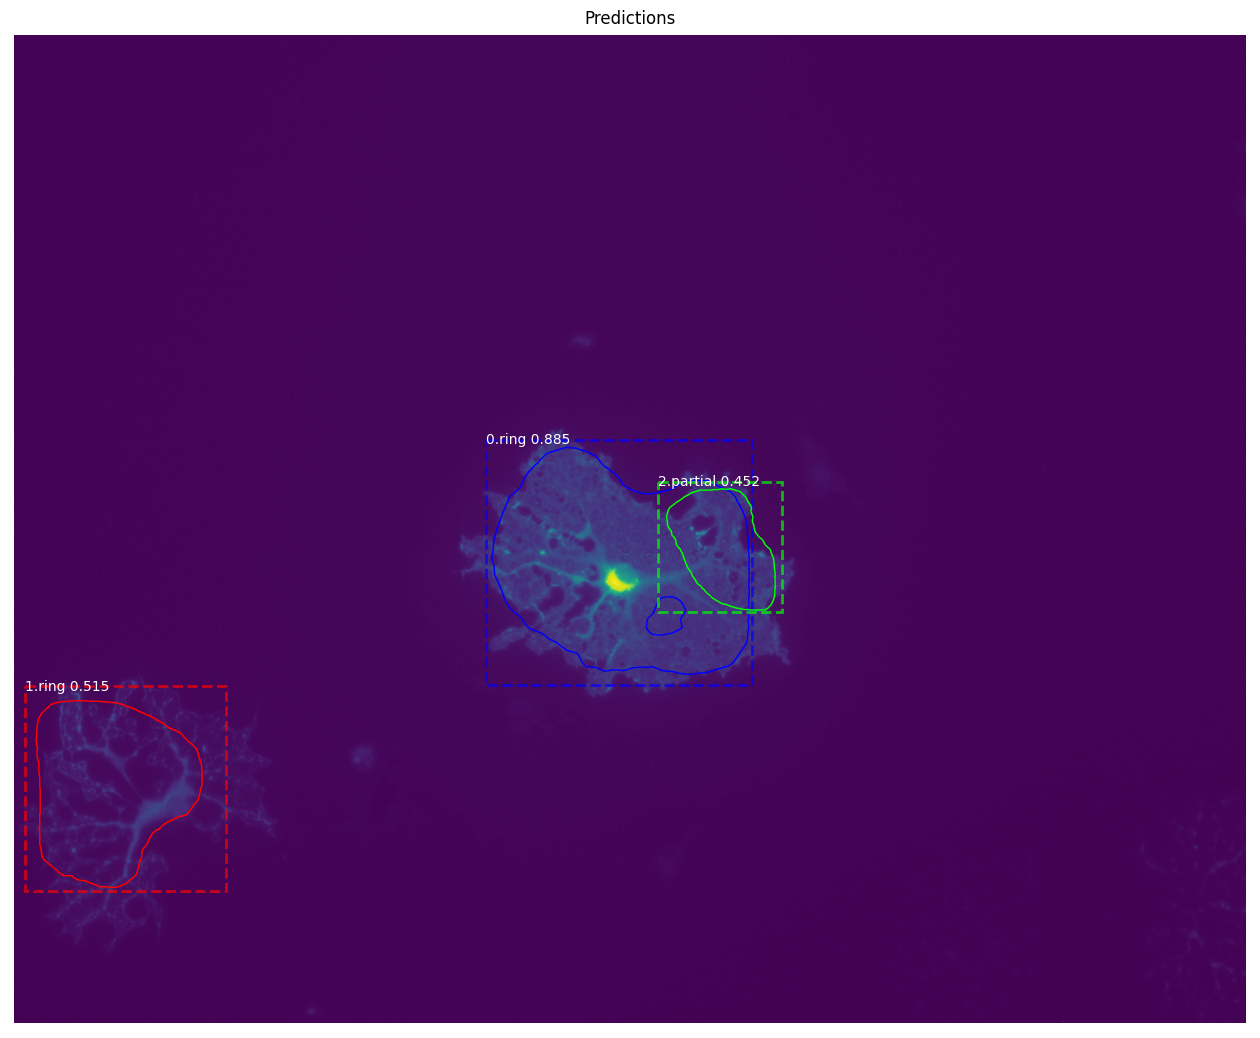

281.it10.20x.r1.9.tif


KeyboardInterrupt: 

In [9]:
TEST_DIR = test_dir

image_paths = []
for filename in os.listdir(TEST_DIR):
    if filename.endswith(".tif"):
        image_paths.append(os.path.join(TEST_DIR, filename))

res_list = []
for image_path in image_paths:
    print(os.path.basename(image_path))
    image = skimage.io.imread(image_path,as_gray=True)*255
    image = np.expand_dims(image.astype(np.uint8), axis=2)
    macro_results = macro_model.detect([image], verbose=0)
    macro_results = nms_suppression_multi(macro_results, 0.3)
    r = macro_results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], 
                                title="Predictions",
                                show_bbox=True, show_mask=False)
    img_res_dir = os.path.join(RESULTS_DIR, os.path.basename(image_path)[:-4])
    os.makedirs(img_res_dir, exist_ok=True)
    for i in range(r['masks'].shape[2]):
        class_name = dataset_val.class_names[r['class_ids'][i]]
        res_list.append([os.path.basename(image_path), i, dataset_val.class_names[r['class_ids'][i]], r['scores'][i], r['rois'][i]])
        cropped_img = image[r['rois'][i][0]:r['rois'][i][2], r['rois'][i][1]:r['rois'][i][3]]
        cv2.imwrite(os.path.join(img_res_dir, f'{i:04d}_' + class_name + '.tif'), cropped_img)

res_df = pd.DataFrame(res_list, columns=['image_name', 'detection_id', 'class', 'score', 'bbox'])
res_df.to_csv(os.path.join(RESULTS_DIR, 'results.csv'), index=False)